In [1]:
## Folder Structure:
# simple_feature_extraction.ipynb (this script)

# asap-aes (folder)
## training_set_rel3.tsv

# supplementary_data
## Kuperman-BRM-data-2012.csv

In [2]:
import os
import math
import time
import random
import scipy
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import textstat
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import pyphen
import syllapy
from spellchecker import SpellChecker

import spacy
#python3 -m spacy download en_core_web_md
from itertools import combinations


# import gingerit
# import languagetool_python

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to /Users/yli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yli/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/yli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
raw_training_set = pd.read_csv('asap-aes/training_set_rel3.tsv',sep='\t', encoding='latin1')
aoa_df = pd.read_csv('supplementary_data/Kuperman-BRM-data-2012.csv') # age of acquisition

In [4]:
print(raw_training_set.shape)
print(raw_training_set.columns)
#raw_training_set.dtypes

(12976, 28)
Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')


In [5]:
raw_training_set[['essay_set', 'domain1_score']].groupby('essay_set', as_index = False).agg(['count', 'mean', 'max', 'min', 'std'])
# I think we should use the essay_set ID as an input too, since the range is so different
# or we can just omit set 2, 7, 8 since they have different rating approaches

essay_set domain1_score                             
                    count       mean max min       std
0         1          1783   8.528323  12   2  1.538565
1         2          1800   3.415556   6   1  0.774512
2         3          1726   1.848204   3   0  0.815157
3         4          1770   1.432203   3   0  0.939782
4         5          1805   2.408864   4   0  0.970821
5         6          1800   2.720000   4   0  0.970630
6         7          1569  16.062460  24   2  4.585350
7         8           723  36.950207  60  10  5.753502

In [6]:
raw_training_set.isna().any(axis = 0)
#raw_training_set.isna().all(axis = 0)

essay_id          False
essay_set         False
essay             False
rater1_domain1    False
rater2_domain1    False
rater3_domain1     True
domain1_score     False
rater1_domain2     True
rater2_domain2     True
domain2_score      True
rater1_trait1      True
rater1_trait2      True
rater1_trait3      True
rater1_trait4      True
rater1_trait5      True
rater1_trait6      True
rater2_trait1      True
rater2_trait2      True
rater2_trait3      True
rater2_trait4      True
rater2_trait5      True
rater2_trait6      True
rater3_trait1      True
rater3_trait2      True
rater3_trait3      True
rater3_trait4      True
rater3_trait5      True
rater3_trait6      True
dtype: bool

In [7]:
essay_str = raw_training_set['essay'][1]

#essay_str.split(' ')
essay_str

"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the i

In [8]:
def get_sets(essay_str):

    words = essay_str.split(' ')
    words = [w for w in words if len(w) > 0]
    words = [w for w in words if w[0] != '@']
    words = [w.lower() for w in words]
    #tokens = word_tokenize(essay_str)
    
    idx_set1 = math.floor(len(words) / 3)
    idx_set2 = idx_set1 + idx_set1
    
    text_set1, text_set2, text_set3 = words[:idx_set1], words[idx_set1:idx_set2], words[idx_set2:]
    text_set1, text_set2, text_set3 = ' '.join(text_set1), ' '.join(text_set2), ' '.join(text_set3)
    #print(len(text_set1), len(text_set2), len(text_set3))

    return text_set1, text_set2, text_set3


def remove_punctuations(x):
    return [re.sub(r'[^\w\s]', '', token) for token in x if re.sub(r'[^\w\s]', '', token)]

def get_avg_AoA(tokens):
    tokens_df = pd.DataFrame({'token': tokens})
    tokens_df = pd.merge(tokens_df, aoa_df[['Word', 'Rating.Mean']], left_on = 'token', right_on = 'Word', how = 'left')
    
    if tokens_df['Rating.Mean'].isna().all():
        avg_aoa = 0
    else:
        avg_aoa = tokens_df['Rating.Mean'].mean()

    return avg_aoa

def get_cohesion_score(text):

    doc = nlp(text)

    # obtain vectors of size (300, ) for each word in the text
    vec_tokens = [token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct]

    # calculate cosine similarity score for combinations of two vectors
    similarities = [np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                    for v1, v2 in combinations(vec_tokens, 2)]
    
    if (len(vec_tokens) < 2) or (len(similarities) > 0):
        return np.mean(similarities)
    else:
        return 0

In [9]:
#text_training_df = raw_training_set[['essay_id', 'essay_set', 'essay']].copy()
text_training_df = raw_training_set[['essay_id', 'essay_set', 'essay']].head(200).copy() # take the first 200 rows to prototype faster

# split each essay into 3 sets, and keep the original essay labeled as "text_original"
text_training_df[['text_set1', 'text_set2', 'text_set3']] = text_training_df['essay'].apply(lambda x: pd.Series(get_sets(x)))
text_training_df = text_training_df.rename(columns = {'essay': 'text_original'})
text_training_df = text_training_df.melt(id_vars=['essay_id', 'essay_set'], value_vars=['text_set1', 'text_set2', 'text_set3', 'text_original'],
                                        var_name='text_set', value_name='text')

# tokenize into words and sentences
text_training_df['word_tokens'] = text_training_df['text'].apply(lambda x: word_tokenize(x))
text_training_df['sent_tokens'] = text_training_df['text'].apply(lambda x: sent_tokenize(x))
text_training_df['word_tokens_clean'] = text_training_df['word_tokens'].apply(lambda x: remove_punctuations(x))

In [10]:
# extract basic statistical features
# (1) total number of words 
# (2) total number of characters
# (3) average number of words per sentence
# (4) total number of sentences
# (5) total number of paragraphs, ---> I don't think we can do this, doesn't seem to be in the raw data
# (6) total number of spelling mistakes
# (7) total number of grammar mistakes ---> I tried multiple packages but no luck. Textblob and transformer worked, but test cases are wrong. Skipped for now. 
# Flesch-Kincaid Score

start_time = time.time()

text_training_df['word_count'] = text_training_df['word_tokens_clean'].apply(lambda x: len(x))
text_training_df['sent_count'] = text_training_df['sent_tokens'].apply(lambda x: len(x))
text_training_df['char_count'] = text_training_df['text'].apply(lambda x: len(x))
text_training_df['sent_length'] = text_training_df['word_count'] / text_training_df['sent_count']

spellcheck = SpellChecker()
text_training_df['spell_err_count'] = text_training_df['word_tokens_clean'].apply(lambda x: len(spellcheck.unknown(x)))
text_training_df['syllabus_count'] = text_training_df['word_tokens_clean'].apply(lambda x: sum(syllapy.count(word) for word in x))
#text_training_df['FleKin_score'] = (0.39 * (text_training_df['word_count'] / text_training_df['sent_count'])) + (11.8 * (text_training_df['syllabus_count'] / text_training_df['word_count'])) - 15.59
# the scores generated from this formula is very different from using flesch_reading_ease
# the formula is also different from wikipedia. Where did you get this?

# text_training_df['FleKin_score'] = 206.835 - (1.015 * (text_training_df['word_count'] / text_training_df['sent_count'])) - (84.6 * (text_training_df['syllabus_count'] / text_training_df['word_count']))
# this formula is from Wikipedia and close to the result of using flesch_reading_ease

text_training_df['FleKin_score'] = text_training_df['text'].apply(lambda x: textstat.flesch_reading_ease(x))

# extras, not in the proposal
text_training_df['DalCha_score'] = text_training_df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
text_training_df['unique_word_count'] = text_training_df['word_tokens_clean'].apply(lambda x: len(set(w.lower() for w in x)))

end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for basic statistical feature extraction: {execution_time:.5f} seconds")

text_training_df.head()


Time taken for basic statistical feature extraction: 19.60543 seconds


,essay_id,essay_set,text_set,text,word_tokens,sent_tokens,word_tokens_clean,word_count,sent_count,char_count,sent_length,spell_err_count,syllabus_count,FleKin_score,DalCha_score,unique_word_count
0,1,1,text_set1,"dear local newspaper, i think effects computer...","[dear, local, newspaper, ,, i, think, effects,...","[dear local newspaper, i think effects compute...","[dear, local, newspaper, i, think, effects, co...",112,7,624,16.000,8,152,78.28,8.13,75
1,2,1,text_set1,dear i believe that using computers will benef...,"[dear, i, believe, that, using, computers, wil...",[dear i believe that using computers will bene...,"[dear, i, believe, that, using, computers, wil...",136,8,767,17.000,6,204,62.68,7.50,90
2,3,1,text_set1,"dear, more and more people use computers, but ...","[dear, ,, more, and, more, people, use, comput...","[dear, more and more people use computers, but...","[dear, more, and, more, people, use, computers...",91,7,519,13.000,2,136,75.30,7.61,70
3,4,1,text_set1,"dear local newspaper, i have found that many e...","[dear, local, newspaper, ,, i, have, found, th...","[dear local newspaper, i have found that many ...","[dear, local, newspaper, i, have, found, that,...",161,8,922,20.125,7,246,59.53,8.65,107
4,5,1,text_set1,dear i know having computers has a positive ef...,"[dear, i, know, having, computers, has, a, pos...",[dear i know having computers has a positive e...,"[dear, i, know, having, computers, has, a, pos...",153,9,823,17.000,2,225,71.14,6.85,90


In [11]:
# https://github.com/mauryquijada/word-complexity-predictor/tree/master
# Supposed to be able to extract these features using machine learning techniques:
    # Lemma length
    # Average age-of-acquisition (at what age a word is most likely to enter someone's vocabulary)
    # Average concreteness (a score of 1 to 5, with 5 being very concrete)
    # Frequency in a certain corpus
    # Lemma frequency in a certain corpus

In [12]:
start_time = time.time() # takes about 30 seconds, mostly on the cohesion score calculation

# content feature extraction 
## sentiments (4 metrics)
## cohesion score, calculated as cosine similarity
## Age of Acquisision score, mapped from the Kuperman dataset

analyzer = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_md")

text_training_df[['neg', 'neu', 'pos', 'compound']] = text_training_df['text'].apply(lambda x: list(analyzer.polarity_scores(x).values())).apply(pd.Series)
text_training_df['cohesion'] = text_training_df['text'].apply(lambda x: get_cohesion_score(x))
text_training_df['AoA_score'] = text_training_df['word_tokens_clean'].apply(lambda x: get_avg_AoA(x))

end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for basic content feature extraction: {execution_time:.5f} seconds")

text_training_df.head()

/Users/yli/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yli/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Time taken for basic content feature extraction: 3026.04910 seconds


,essay_id,essay_set,text_set,text,word_tokens,sent_tokens,word_tokens_clean,word_count,sent_count,char_count,...,syllabus_count,FleKin_score,DalCha_score,unique_word_count,neg,neu,pos,compound,cohesion,AoA_score
0,1,1,text_set1,"dear local newspaper, i think effects computer...","[dear, local, newspaper, ,, i, think, effects,...","[dear local newspaper, i think effects compute...","[dear, local, newspaper, i, think, effects, co...",112,7,624,...,152,78.28,8.13,75,0.000,0.847,0.153,0.9550,0.248577,5.925000
1,2,1,text_set1,dear i believe that using computers will benef...,"[dear, i, believe, that, using, computers, wil...",[dear i believe that using computers will bene...,"[dear, i, believe, that, using, computers, wil...",136,8,767,...,204,62.68,7.50,90,0.015,0.787,0.198,0.9678,0.312173,6.014722
2,3,1,text_set1,"dear, more and more people use computers, but ...","[dear, ,, more, and, more, people, use, comput...","[dear, more and more people use computers, but...","[dear, more, and, more, people, use, computers...",91,7,519,...,136,75.30,7.61,70,0.016,0.670,0.314,0.9896,0.313247,5.671034
3,4,1,text_set1,"dear local newspaper, i have found that many e...","[dear, local, newspaper, ,, i, have, found, th...","[dear local newspaper, i have found that many ...","[dear, local, newspaper, i, have, found, that,...",161,8,922,...,246,59.53,8.65,107,0.024,0.762,0.214,0.9891,0.237326,6.175490
4,5,1,text_set1,dear i know having computers has a positive ef...,"[dear, i, know, having, computers, has, a, pos...",[dear i know having computers has a positive e...,"[dear, i, know, having, computers, has, a, pos...",153,9,823,...,225,71.14,6.85,90,0.000,0.816,0.184,0.9828,0.244275,5.864906


In [17]:
basic_feature_train = text_training_df.merge(raw_training_set[['essay_id', 'domain1_score', 'domain2_score']], on = ['essay_id'], how = 'left')
basic_feature_train.to_csv('basic_feature_train_data.csv', index = False)

In [14]:
## this works but it works so badly
# from textblob import TextBlob

# text = "This sentense have grammar issue."
# blob = TextBlob(text)
# corrected_text = str(blob.correct())

# print("Corrected Text:", corrected_text)

# # Counting grammar mistakes by comparing changes
# original_words = text.split()
# corrected_words = str(corrected_text).split()
# num_mistakes = sum(1 for orig, corr in zip(original_words, corrected_words) if orig != corr)
# print("Number of Grammar Mistakes:", num_mistakes)

### n-grams test

In [138]:
# generate N-grams

vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df = 2, stop_words='english')  # Generates bigrams only
# Transform the text data into a feature matrix
bigrams_feature_X = vectorizer.fit_transform(text_training_df['text'])

# min_df and max_df are supposed to limit the number of ngrams generated
# for example, min_df = 2 means the ngram has to appear in at least two essays to be counted
# max_df = 0.8 means ngrams appearing in >80% of the essays will not be counted
# however it didn't really make much of a difference to the number of columns
# removing stop_words reduced the number of columns by about 30%



print("Feature names (n-grams):", vectorizer.get_feature_names_out())
print("Feature matrix:\n", ngrams_feature_X.toarray())

# ngrams_feature_X will be a sparse matrix with #row = #rows in input df, #columns = # of unique bigrams/trigrams
# with 800 rows in the input data (200 raw essays), and generating both bigrams and trigrams, the feature matrix has >90k column
# with bigrams only, it's about 30k columns

# since it is sparse, apparently some models like random forest do not handle sparse matrices well
# although svm is supposed to work well with sparse matrices
# I used truncated SVD to reduce the number of dimensions
# because apparently truncated SVD work better than PCA on sparse matrices 

ngrams_feature_X.shape

Feature names (n-grams): ['abd yor' 'abduction memories' 'abile message' ... 'zombie hared'
 'zombies believe' 'zone computer']
Feature matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(800, 20271)

In [140]:
# test the number of components we should keep for the feature matrix

start_time = time.time() 

n_comp_ls = [int(x) for x in np.linspace(50, 1000, int(1000/50))]
explained_var_ls = []

for n_components in n_comp_ls:
    svd = TruncatedSVD(n_components=n_components)  # Adjust n_components based on dataset size
    X_reduced = svd.fit_transform(bigrams_feature_X)
#    print(X_reduced.shape)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"{n_components} components has total explained variance: {explained_variance:.2f}")
    explained_var_ls.append(explained_variance)

end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for SVD decomposition testing: {execution_time:.5f} seconds")


50 components has total explained variance: 0.15
100 components has total explained variance: 0.28
150 components has total explained variance: 0.40
200 components has total explained variance: 0.52
250 components has total explained variance: 0.59
300 components has total explained variance: 0.65
350 components has total explained variance: 0.71
400 components has total explained variance: 0.78
450 components has total explained variance: 0.83
500 components has total explained variance: 0.89
550 components has total explained variance: 0.95
600 components has total explained variance: 0.99
650 components has total explained variance: 1.00
700 components has total explained variance: 1.00
750 components has total explained variance: 1.00
800 components has total explained variance: 1.00
850 components has total explained variance: 1.00
900 components has total explained variance: 1.00
950 components has total explained variance: 1.00
1000 components has total explained variance: 1.00


Text(0.5, 1.0, 'Dimension Reduction for Bi-gram Feature Vector')

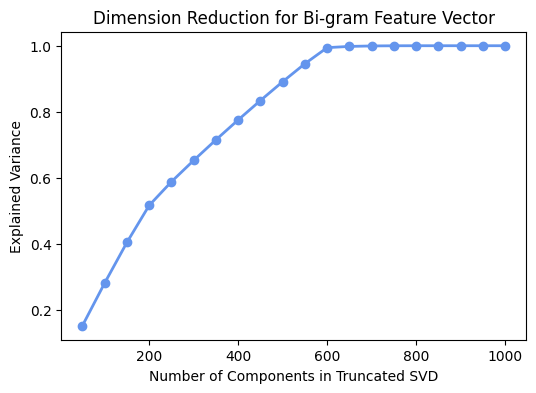

In [137]:
plt.figure(figsize=(6, 4))
plt.plot(n_comp_ls, explained_var_ls, marker='o', color='cornflowerblue', linestyle='-', linewidth=2)
#plt.bar(n_comp_ls, explained_var_ls, color='cornflowerblue', width = 25)

plt.xlabel("Number of Components in Truncated SVD")
plt.ylabel("Explained Variance")
plt.title("Dimension Reduction for Bi-gram Feature Vector")

# looks like 600 components is definitely enough, question is we want to go even lower 

In [148]:
#test a number of n_components, plot the elbow chart for explained variance
svd = TruncatedSVD(n_components=600)  # Adjust n_components based on dataset size
bigrams_X_reduced = svd.fit_transform(bigrams_feature_X)
print(bigrams_X_reduced.shape)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance: {explained_variance:.2f}")

(800, 600)
Total explained variance: 0.99


In [142]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3))  # Generates unigrams, bigrams, and trigrams

# Transform the text data into a feature matrix
trigrams_feature_X = vectorizer.fit_transform(text_training_df['text'])
print("Feature names (n-grams):", vectorizer.get_feature_names_out())
print("Feature matrix:\n", X.toarray())

X.shape

Feature names (n-grams): ['abd yor can' 'abduction from their' 'abile to message' ...
 'zombie hared or' 'zombies believe that' 'zone to their']
Feature matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(800, 95489)

In [143]:
# test the number of components we should keep for the feature matrix

start_time = time.time() 

n_comp_ls = [int(x) for x in np.linspace(50, 1000, int(1000/50))]
explained_var_trigrams_ls = []

for n_components in n_comp_ls:
    svd = TruncatedSVD(n_components=n_components)  # Adjust n_components based on dataset size
    X_reduced = svd.fit_transform(trigrams_feature_X)
#    print(X_reduced.shape)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"{n_components} components has total explained variance: {explained_variance:.2f}")
    explained_var_trigrams_ls.append(explained_variance)

end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for SVD decomposition testing: {execution_time:.5f} seconds")


50 components has total explained variance: 0.13
100 components has total explained variance: 0.26
150 components has total explained variance: 0.38
200 components has total explained variance: 0.49
250 components has total explained variance: 0.56
300 components has total explained variance: 0.62
350 components has total explained variance: 0.69
400 components has total explained variance: 0.75
450 components has total explained variance: 0.81
500 components has total explained variance: 0.87
550 components has total explained variance: 0.93
600 components has total explained variance: 0.98
650 components has total explained variance: 0.99
700 components has total explained variance: 1.00
750 components has total explained variance: 1.00
800 components has total explained variance: 1.00
850 components has total explained variance: 1.00
900 components has total explained variance: 1.00
950 components has total explained variance: 1.00
1000 components has total explained variance: 1.00


Text(0.5, 1.0, 'Dimension Reduction for Tri-gram Feature Vector')

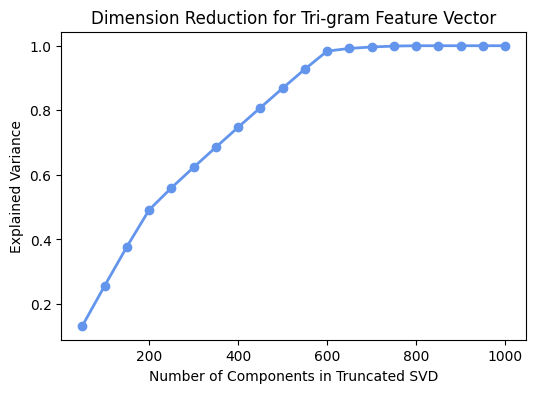

In [145]:
plt.figure(figsize=(6, 4))
plt.plot(n_comp_ls, explained_var_trigrams_ls, marker='o', color='cornflowerblue', linestyle='-', linewidth=2)
#plt.bar(n_comp_ls, explained_var_ls, color='cornflowerblue', width = 25)

plt.xlabel("Number of Components in Truncated SVD")
plt.ylabel("Explained Variance")
plt.title("Dimension Reduction for Tri-gram Feature Vector")

# looks like 600 components is definitely enough, question is we want to go even lower 

In [147]:
#test a number of n_components, plot the elbow chart for explained variance
svd = TruncatedSVD(n_components=600)  # Adjust n_components based on dataset size
trigrams_X_reduced = svd.fit_transform(trigrams_feature_X)
print(trigrams_X_reduced.shape)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance: {explained_variance:.2f}")

(800, 600)
Total explained variance: 0.98


In [152]:
bigrams_training_df = text_training_df[['essay_id', 'essay_set', 'text_set']].copy()
bigrams_training_df

,essay_id,essay_set,text_set
0,1,1,text_set1
1,2,1,text_set1
2,3,1,text_set1
3,4,1,text_set1
4,5,1,text_set1
...,...,...,...
795,196,1,text_original
796,197,1,text_original
797,198,1,text_original
798,199,1,text_original


In [153]:
bigrams_training_df = pd.merge(bigrams_training_df, pd.DataFrame(bigrams_X_reduced), left_index=True, right_index=True)
bigrams_training_df

,essay_id,essay_set,text_set,0,1,2,3,4,5,6,...,590,591,592,593,594,595,596,597,598,599
0,1,1,text_set1,0.052285,-0.048203,0.022007,-0.011722,0.006695,-0.022119,0.054146,...,-0.012152,0.002902,0.023891,-0.002582,-0.016212,-0.013114,0.016690,0.018779,-0.004733,0.001591
1,2,1,text_set1,0.059946,-0.036164,-0.011643,-0.073629,-0.031404,-0.034246,-0.043288,...,-0.002467,0.004277,-0.015686,-0.002089,-0.009289,0.004231,0.023650,-0.000468,-0.000597,-0.000446
2,3,1,text_set1,0.153208,-0.139122,0.092557,0.092743,0.131181,-0.124264,-0.053691,...,0.051913,-0.066358,0.047468,0.086166,-0.014344,-0.008609,0.005223,0.032545,-0.024253,0.002259
3,4,1,text_set1,0.040047,-0.040288,0.007502,-0.058927,-0.011478,-0.044960,0.026540,...,0.004942,-0.002011,0.002885,-0.006553,0.007458,-0.010124,0.003495,-0.002726,-0.000268,-0.001244
4,5,1,text_set1,0.072841,-0.027714,0.099167,0.038827,-0.029055,-0.006977,-0.021740,...,-0.007569,-0.004627,0.005155,0.005997,0.009513,0.005826,-0.003362,0.006940,0.011037,0.004816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,196,1,text_original,0.127906,-0.147025,0.023027,-0.241771,0.101880,0.035952,-0.101978,...,-0.000266,0.004725,0.000821,0.003086,-0.003910,-0.001217,0.001487,-0.009071,-0.001718,0.004103
796,197,1,text_original,0.031144,-0.030288,0.011024,-0.037032,-0.013221,0.046274,-0.019187,...,0.001073,0.001404,-0.001328,-0.000471,0.000349,0.000416,-0.001820,0.000602,-0.001681,-0.000516
797,198,1,text_original,0.047551,-0.062400,-0.014029,0.046331,-0.008669,0.032616,-0.004130,...,0.000656,-0.000801,-0.000427,-0.002505,-0.000416,0.000279,-0.001210,-0.001911,0.003887,0.000240
798,199,1,text_original,0.057067,-0.134412,-0.089338,0.099900,-0.051741,0.002848,-0.003252,...,-0.000214,0.002762,0.003331,-0.002512,-0.002328,-0.001641,0.003334,0.003038,0.001703,-0.000170


In [51]:
# def correct_spelling_mistakes(text):
#     # Split text into words
#     words = text.split()
#     spell = SpellChecker()
    
#     # Correct the misspelled words
#     corrected_words = []

    
#     corrected_words = [w if (w in spell) else spell.correction(w) for w in words]
#     print(corrected_words)
#     print(len(corrected_words))
#     corrected_text = " ".join(corrected_words)
    
#     return corrected_text


In [50]:
# text = text_training_df.loc[0, 'text']
# words = text.split()
# spell = SpellChecker()

# corrected_words = []
# corrected_words = [w if ((w in spell) and (len(w))>0) else spell.correction(w) for w in words]
# print(corrected_words)
# print(len(corrected_words))
# corrected_text = " ".join(corrected_words)

['dear', 'local', 'newspaper', 'i', 'think', 'effects', 'computers', 'have', 'on', 'people', 'are', 'great', 'learning', None, 'because', 'they', 'give', 'us', 'time', 'to', 'chat', 'with', None, 'people', 'helps', 'us', 'learn', 'about', 'the', None, 'and', 'keeps', 'us', 'out', 'of', 'problem', 'thing', 'about', "don't", 'you', 'think', 'so', 'how', 'would', 'you', 'feel', 'if', 'your', 'teenager', 'is', 'always', 'on', 'the', 'phone', 'with', 'friends', 'do', 'you', 'ever', 'time', 'to', 'chat', 'with', 'your', 'friends', 'or', 'business', 'partner', 'about', 'things', 'well', 'now', '-', "there's", 'a', 'new', 'way', 'to', 'chat', 'the', 'computer', 'theirs', 'plenty', 'of', 'sites', 'on', 'the', 'internet', 'to', 'do', 'so', None, 'space', 'eat', 'just', 'think', 'now', 'while', 'your', 'setting', 'up', 'meeting', 'with', 'your', 'boss', 'on', 'the', 'computer', 'your', 'teenager', 'is']
111


TypeError: sequence item 13: expected str instance, NoneType found

In [61]:
# text = text_training_df.loc[0, 'text']
# words = text.split()
# print(text)
# print('-----')
# for word in words:
#     if word in spell:
#         corrected_words.append(word)  # Word is spelled correctly
#     else:
#         # Replace with the most likely correction
#         corrected_words.append(spell.correction(word))
#         print('wrong word:', word, '-->>> corrected:', spell.correction(word))

# # Join the corrected words back into a single string
# corrected_text = " ".join(corrected_words)


dear local newspaper, i think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! thing about! dont you think so? how would you feel if your teenager is always on the phone with friends! do you ever time to chat with your friends or buisness partner about things. well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: facebook, myspace ect. just think now while your setting up meeting with your boss on the computer, your teenager is
-----
wrong word: newspaper, -->>> corrected: newspaper
wrong word: skills/affects -->>> corrected: None
wrong word: friends/new -->>> corrected: None
wrong word: people, -->>> corrected: people
wrong word: globe(astronomy) -->>> corrected: None
wrong word: troble! -->>> corrected: problem
wrong word: about! -->>> corrected: about
wrong word: dont -->>> corrected: don't
wr

TypeError: sequence item 13: expected str instance, NoneType found

In [60]:
# text = text_training_df.loc[0, 'text']
# words = text_training_df.loc[0, 'word_tokens_clean']
# print(text)
# print('-----')
# for word in words:
#     if word in spell:
#         corrected_words.append(word)  # Word is spelled correctly
#     else:
#         # Replace with the most likely correction
#         corrected_words.append(spell.correction(word))
#         print('wrong word:', word, '-->>> corrected:', spell.correction(word))

# # Join the corrected words back into a single string
# corrected_text = " ".join(corrected_words)


dear local newspaper, i think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! thing about! dont you think so? how would you feel if your teenager is always on the phone with friends! do you ever time to chat with your friends or buisness partner about things. well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: facebook, myspace ect. just think now while your setting up meeting with your boss on the computer, your teenager is
-----
wrong word: skillsaffects -->>> corrected: None
wrong word: friendsnew -->>> corrected: None
wrong word: troble -->>> corrected: trouble
wrong word: dont -->>> corrected: don't
wrong word: buisness -->>> corrected: business
wrong word: facebook -->>> corrected: casebook
wrong word: myspace -->>> corrected: space
wrong word: ect -->>> corrected: eat


TypeError: sequence item 13: expected str instance, NoneType found